<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Base" data-toc-modified-id="Base-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Base</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Create-Index" data-toc-modified-id="Create-Index-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Create Index</a></span></li><li><span><a href="#Поиск" data-toc-modified-id="Поиск-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Поиск</a></span></li><li><span><a href="#new-train-DataFrame" data-toc-modified-id="new-train-DataFrame-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>new train DataFrame</a></span></li><li><span><a href="#Desicion-Tree" data-toc-modified-id="Desicion-Tree-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Desicion Tree</a></span></li><li><span><a href="#New-Features" data-toc-modified-id="New-Features-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>New Features</a></span></li></ul></div>

In [1]:
!pip install faiss-cpu

In [2]:
!pip install catboost

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import faiss
from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

RANDOM_S = 12345

## Base

In [4]:
base = pd.read_csv('base.csv')

In [5]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2918139 entries, 0 to 2918138
Data columns (total 73 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Id      object 
 1   0       float64
 2   1       float64
 3   2       float64
 4   3       float64
 5   4       float64
 6   5       float64
 7   6       float64
 8   7       float64
 9   8       float64
 10  9       float64
 11  10      float64
 12  11      float64
 13  12      float64
 14  13      float64
 15  14      float64
 16  15      float64
 17  16      float64
 18  17      float64
 19  18      float64
 20  19      float64
 21  20      float64
 22  21      float64
 23  22      float64
 24  23      float64
 25  24      float64
 26  25      float64
 27  26      float64
 28  27      float64
 29  28      float64
 30  29      float64
 31  30      float64
 32  31      float64
 33  32      float64
 34  33      float64
 35  34      float64
 36  35      float64
 37  36      float64
 38  37      float64
 39  38      float64
 40  

In [6]:
num = base.copy().select_dtypes(exclude='object')
num = num.columns.to_list()

In [7]:
# проведем масштабирование признаков товаров base:
scaler = StandardScaler()
scaler.fit(base[num])

StandardScaler()

In [8]:
base[num] = scaler.transform(base[num])

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>,
        <Axes: title={'center': '4'}>, <Axes: title={'center': '5'}>,
        <Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>],
       [<Axes: title={'center': '8'}>, <Axes: title={'center': '9'}>,
        <Axes: title={'center': '10'}>, <Axes: title={'center': '11'}>,
        <Axes: title={'center': '12'}>, <Axes: title={'center': '13'}>,
        <Axes: title={'center': '14'}>, <Axes: title={'center': '15'}>],
       [<Axes: title={'center': '16'}>, <Axes: title={'center': '17'}>,
        <Axes: title={'center': '18'}>, <Axes: title={'center': '19'}>,
        <Axes: title={'center': '20'}>, <Axes: title={'center': '21'}>,
        <Axes: title={'center': '22'}>, <Axes: title={'center': '23'}>],
       [<Axes: title={'center': '24'}>, <Axes: title={'center': '25'}>,
        <Axes: title={'center': '26'}>, <Axes: title={'center': '27'}>,

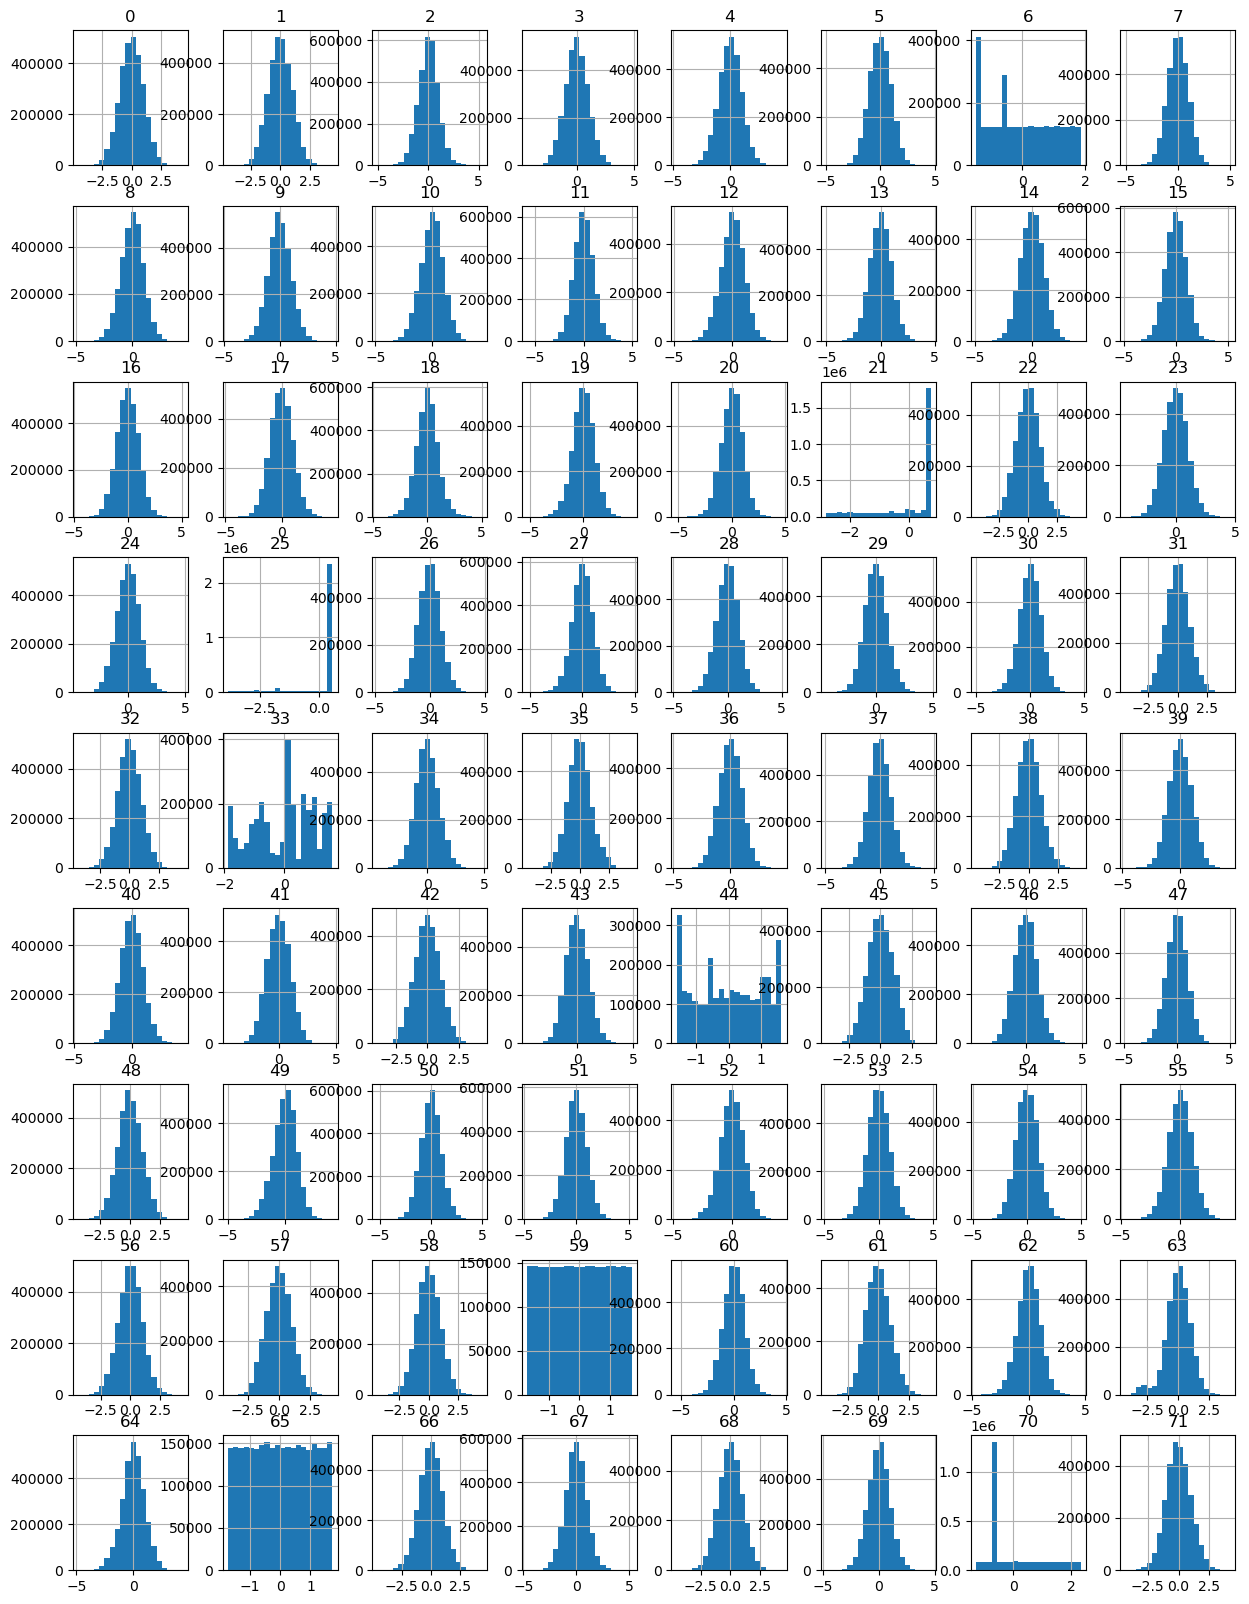

In [9]:
# посмотрим распределение признаков:
base.hist(figsize=(15,20), bins=20)

In [10]:
base_faiss = base.drop(['Id','6','21','25','33', '44','59','65','70'], axis=1)

In [11]:
base_faiss.shape

(2918139, 64)

## Train

In [12]:
train = pd.read_csv('train.csv')
train.head()

,Id,0,1,2,3,4,5,6,7,8,...,63,64,65,66,67,68,69,70,71,Target
0,0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1,1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2,2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3,3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4,4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


In [13]:
targets = train['Target']

In [14]:
num = train.copy().select_dtypes(exclude='object')
num = num.columns.to_list()

In [15]:
train[num] = scaler.transform(train[num])

In [16]:
train_faiss = train.drop(['Id','Target','6','21','25','33', '44','59','65','70'], axis=1)

## Create Index

In [17]:
dims = base_faiss.shape[1]
n_cells = 100
# how many cells
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [18]:
idx_l2.train(np.ascontiguousarray(base_faiss.values[:50000]).astype('float32'))

idx_l2.add(np.ascontiguousarray(base_faiss.values).astype('float32'))

In [19]:
base_index = {k: v for k, v in enumerate(base["Id"].to_list())}

## Поиск

Найдем 30 ближайших соседей для обучения ML-модели

In [20]:
k2 = 30
r, idx = idx_l2.search(np.ascontiguousarray(train_faiss.values).astype('float32'), k2)

In [21]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(f'accuracy@30: {100 * acc / len(idx)}')

accuracy@30: 67.147


In [22]:
len(idx)

100000

In [23]:
del train_faiss, base_faiss

## new train 

Соберем новый датафрейм для обучения модели бинарной классификации. Основой станет датасет с запросами train, дополненный каждым индексом товара и признаками товара из 30 ближайших найденных соседей из выдачи faiss

In [24]:
# размножим датасет train в 30 раз:
new_index = train.index.repeat(k2)
train_repeated = train.loc[new_index].reset_index(drop=True)

train_repeated.shape

(3000000, 74)

In [25]:
train_repeated

,Id,0,1,2,3,4,5,6,7,8,...,63,64,65,66,67,68,69,70,71,Target
0,0-query,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,-2.296794,...,1.274319,-0.02441,-1.173481,-1.035388,0.197184,-0.200786,0.906575,0.995267,0.522963,675816-base
1,0-query,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,-2.296794,...,1.274319,-0.02441,-1.173481,-1.035388,0.197184,-0.200786,0.906575,0.995267,0.522963,675816-base
2,0-query,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,-2.296794,...,1.274319,-0.02441,-1.173481,-1.035388,0.197184,-0.200786,0.906575,0.995267,0.522963,675816-base
3,0-query,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,-2.296794,...,1.274319,-0.02441,-1.173481,-1.035388,0.197184,-0.200786,0.906575,0.995267,0.522963,675816-base
4,0-query,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,-2.296794,...,1.274319,-0.02441,-1.173481,-1.035388,0.197184,-0.200786,0.906575,0.995267,0.522963,675816-base
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,99999-query,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,1.149390,0.885642,-0.902251,...,-0.973232,0.48528,-0.940010,-0.497456,0.398868,0.897089,-0.704127,1.960963,-0.775166,2769109-base
2999996,99999-query,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,1.149390,0.885642,-0.902251,...,-0.973232,0.48528,-0.940010,-0.497456,0.398868,0.897089,-0.704127,1.960963,-0.775166,2769109-base
2999997,99999-query,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,1.149390,0.885642,-0.902251,...,-0.973232,0.48528,-0.940010,-0.497456,0.398868,0.897089,-0.704127,1.960963,-0.775166,2769109-base
2999998,99999-query,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,1.149390,0.885642,-0.902251,...,-0.973232,0.48528,-0.940010,-0.497456,0.398868,0.897089,-0.704127,1.960963,-0.775166,2769109-base


In [26]:
# переименуем признаки запроса:
for column in train_repeated.columns:
    train_repeated.rename(columns = {column : f'train_{column}'}, inplace = True )

In [27]:
all_indices = [idx for sublist in idx for idx in sublist] # список индексов faiss
all_distances = [dist for sublist in r for dist in sublist] # список расстояний faiss

# добавим индексы товара и дистанцию из выдачи faiss в размноженный датасет:
train_repeated['base_index'] = all_indices
train_repeated['distance'] = all_distances

In [28]:
# добавим индексы товара из словаря:
train_repeated['Id'] = train_repeated['base_index'].map(base_index)

In [29]:
train_ml = train_repeated.merge(base, on='Id')

In [30]:
# создадим бинарный признак если индекс выбранного товара совпал с целью:
train_ml['binar_target'] = (train_ml['train_Target'] == train_ml['Id']).astype(int)

In [31]:
train_ml.head()

,train_Id,train_0,train_1,train_2,train_3,train_4,train_5,train_6,train_7,train_8,...,63,64,65,66,67,68,69,70,71,binar_target
0,0-query,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,-2.296794,...,1.723392,-0.369458,0.988497,-1.100241,0.280916,-0.492041,0.532096,0.543575,0.090279,0
1,901-query,1.916994,1.153344,-0.199909,-1.319427,-0.193553,-0.269549,-1.287975,0.345101,-0.892164,...,1.723392,-0.369458,0.988497,-1.100241,0.280916,-0.492041,0.532096,0.543575,0.090279,0
2,16747-query,0.429194,1.314741,-0.513722,-1.220226,1.779113,0.047929,1.152288,0.592973,-2.010040,...,1.723392,-0.369458,0.988497,-1.100241,0.280916,-0.492041,0.532096,0.543575,0.090279,0
3,17014-query,0.310627,1.782069,1.165392,-1.973650,0.477932,-0.405355,0.250346,-0.103791,-1.668594,...,1.723392,-0.369458,0.988497,-1.100241,0.280916,-0.492041,0.532096,0.543575,0.090279,0
4,21887-query,-0.265206,2.188731,0.442868,-1.624284,1.152030,-0.141081,0.882876,1.339122,-0.821816,...,1.723392,-0.369458,0.988497,-1.100241,0.280916,-0.492041,0.532096,0.543575,0.090279,0


In [32]:
# проверка:
sum(train_ml['binar_target'])

67147

## Desicion Tree

## New Features

Посмотрим как взаимодействуют наиболее важные признаки

In [33]:
X_reg  = train_ml[['train_6', 'train_25', 'train_33', 'train_44', 'train_45', 'train_70', 'distance', '6','25','33', '44', '45','70']]

array([[<Axes: title={'center': 'train_6'}>,
        <Axes: title={'center': 'train_25'}>,
        <Axes: title={'center': 'train_33'}>,
        <Axes: title={'center': 'train_44'}>],
       [<Axes: title={'center': 'train_45'}>,
        <Axes: title={'center': 'train_70'}>,
        <Axes: title={'center': 'distance'}>,
        <Axes: title={'center': '6'}>],
       [<Axes: title={'center': '25'}>, <Axes: title={'center': '33'}>,
        <Axes: title={'center': '44'}>, <Axes: title={'center': '45'}>],
       [<Axes: title={'center': '70'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

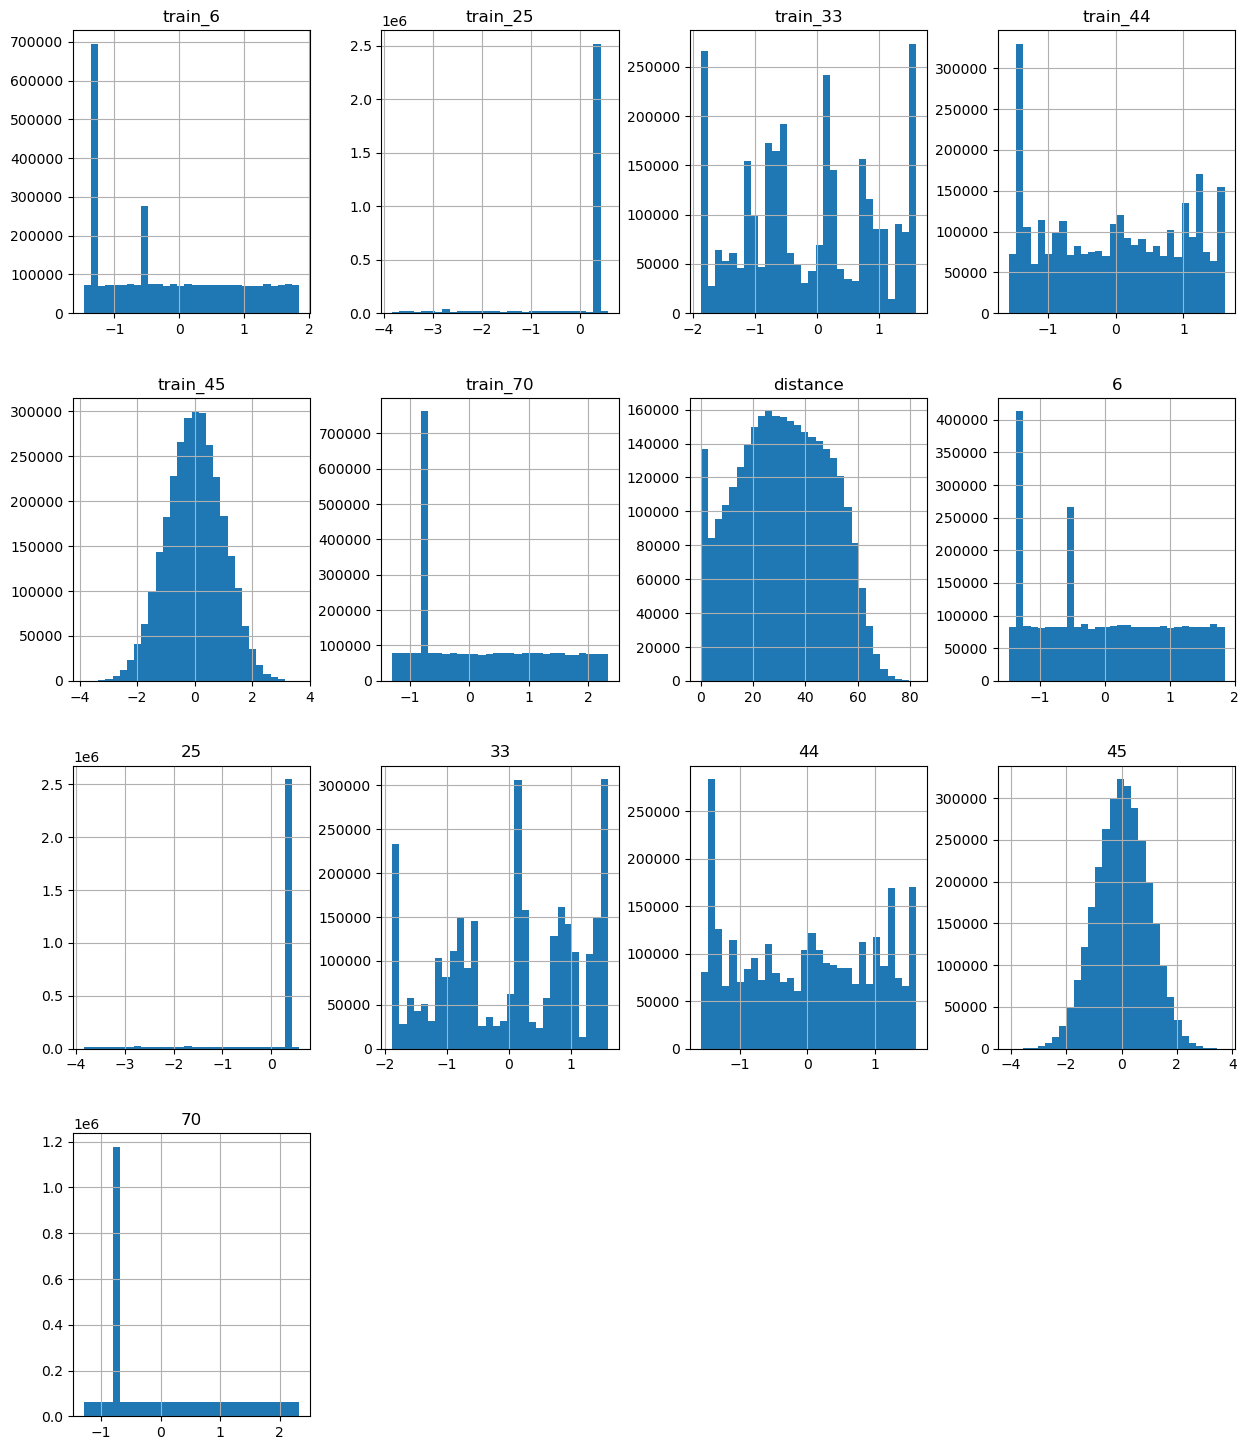

In [34]:
X_reg.hist(figsize=(15, 18), bins=30)

В перечень самых важных признаков попали признаки с распеределением, далеким от нормального. Они были ислючены из обучения индекса фаисса.

Распределение парных признаков соответствующих запроса и товара очень похожи друг на друга, посмотрим в какой части они полностью совпадают. Распределение значений признака 'distance' далеко от нормального.

<Axes: >

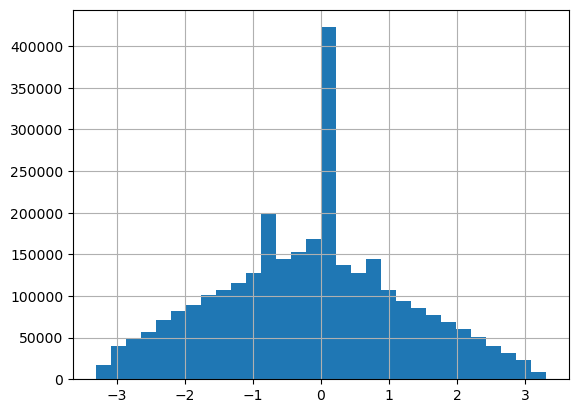

In [35]:
train_ml['sin_6'] = train_ml['train_6'] - train_ml['6']
train_ml['sin_6'].hist(bins=30)

In [36]:
train_ml['sin_6'].value_counts()

sin_6
 0.000000    263670
-0.844827     60976
 0.844827     24587
-1.040497       890
-1.004402       784
              ...  
-1.904694         1
-0.163213         1
-0.521843         1
-1.640476         1
 1.632885         1
Name: count, Length: 2122976, dtype: int64

In [37]:
train_ml['sin_6'] = [1 if x == 0 else 0 for x in train_ml['sin_6']]

In [38]:
train_ml['sin_25'] = train_ml['train_25'] - train_ml['25']

In [39]:
train_ml['sin_25'].value_counts(normalize=True)

sin_25
 0.000000    7.361033e-01
-3.104378    5.177000e-03
 3.104378    2.054333e-03
 2.174370    1.521333e-03
-0.547466    8.910000e-04
                 ...     
 0.421030    3.333333e-07
-0.043424    3.333333e-07
-0.208097    3.333333e-07
 2.652774    3.333333e-07
 3.746982    3.333333e-07
Name: proportion, Length: 248975, dtype: float64

In [40]:
train_ml['sin_25'] = [1 if x == 0 else 0 for x in train_ml['sin_25']]

<Axes: >

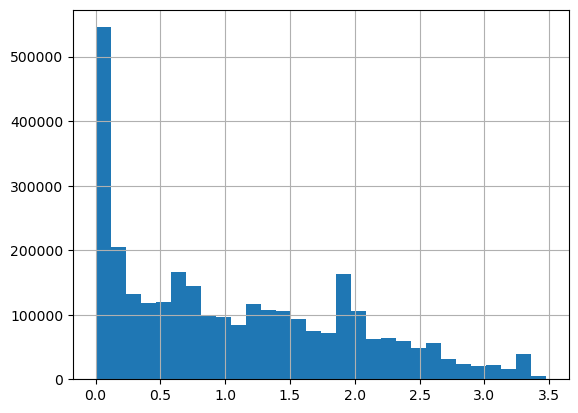

In [41]:
train_ml['sin_33'] = abs(train_ml['train_33'] - train_ml['33'])
train_ml['sin_33'].hist(bins=30)

In [42]:
train_ml['sin_33'].value_counts()

sin_33
0.000000    390191
1.876759     75482
2.059795     37225
0.183036     36300
1.431219     34435
             ...  
1.779675         1
0.655952         1
0.465028         1
0.555338         1
2.596202         1
Name: count, Length: 163614, dtype: int64

In [43]:
train_ml['sin_44'] = train_ml['train_44'] - train_ml['44']
train_ml['sin_44'] .value_counts().head(10)

sin_44
 0.000000e+00    777029
 1.986124e+00      8535
-5.224869e-01      6550
 5.224869e-01      6037
-1.824807e+00      5800
-1.986124e+00      5628
-2.220446e-16      4503
 1.824807e+00      4331
-2.457942e+00      4253
 2.027670e+00      3962
Name: count, dtype: int64

<Axes: >

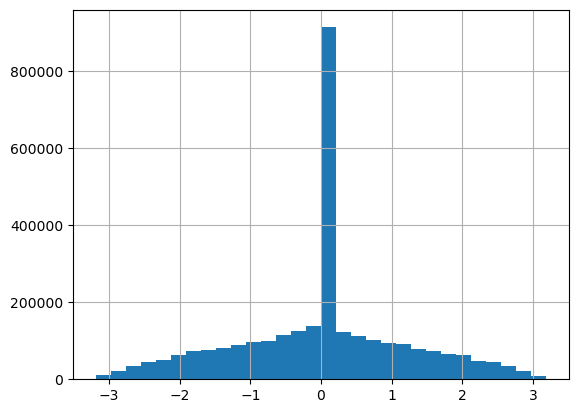

In [44]:
train_ml['sin_44'] .hist(bins=30)

In [45]:
train_ml['sin_44'] = [1 if x == 0 else 0 for x in train_ml['sin_44']]

In [46]:
train_ml['sin_44'].value_counts()

sin_44
0    2222971
1     777029
Name: count, dtype: int64

<Axes: >

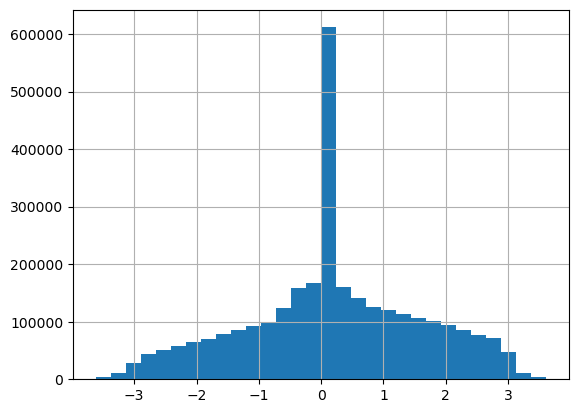

In [47]:
train_ml['sin_70'] = train_ml['train_70'] - train_ml['70']
train_ml['sin_70'].hist(bins=30)

In [48]:
train_ml['sin_70'].value_counts()

sin_70
 0.000000    445115
 1.237565       457
-1.237565       313
 0.195571       109
 1.993149       106
              ...  
 2.454418         1
-1.325596         1
 1.103527         1
-0.123974         1
 3.076721         1
Name: count, Length: 1698439, dtype: int64

In [49]:
train_ml['sin_70'] = [1 if x == 0 else 0 for x in train_ml['sin_70']]

Не все признаки запроса и товара совпадают друг с другом, но такие совпадения есть. Подсветим их для модели, обозначив такое полное совпадение единицей

In [50]:
train_ml.columns.to_list()

['train_Id',
 'train_0',
 'train_1',
 'train_2',
 'train_3',
 'train_4',
 'train_5',
 'train_6',
 'train_7',
 'train_8',
 'train_9',
 'train_10',
 'train_11',
 'train_12',
 'train_13',
 'train_14',
 'train_15',
 'train_16',
 'train_17',
 'train_18',
 'train_19',
 'train_20',
 'train_21',
 'train_22',
 'train_23',
 'train_24',
 'train_25',
 'train_26',
 'train_27',
 'train_28',
 'train_29',
 'train_30',
 'train_31',
 'train_32',
 'train_33',
 'train_34',
 'train_35',
 'train_36',
 'train_37',
 'train_38',
 'train_39',
 'train_40',
 'train_41',
 'train_42',
 'train_43',
 'train_44',
 'train_45',
 'train_46',
 'train_47',
 'train_48',
 'train_49',
 'train_50',
 'train_51',
 'train_52',
 'train_53',
 'train_54',
 'train_55',
 'train_56',
 'train_57',
 'train_58',
 'train_59',
 'train_60',
 'train_61',
 'train_62',
 'train_63',
 'train_64',
 'train_65',
 'train_66',
 'train_67',
 'train_68',
 'train_69',
 'train_70',
 'train_71',
 'train_Target',
 'base_index',
 'distance',
 'Id',
 '0',
 '1

In [51]:
X_log = train_ml.drop(['train_Id','train_Target','Id', 'binar_target', 'base_index'], axis=1).astype('float32')
y_log = train_ml['binar_target']

In [52]:
X_train, X_val, y_train, y_val = train_test_split(X_log, y_log, test_size=0.2, random_state=42)

In [53]:
from sklearn.linear_model import LogisticRegression
model_l = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')

In [54]:
model_l.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=12345,
                   solver='liblinear')

In [55]:
pred_2 = model_l.predict(X_val)
print(sum(pred_2), sum(y_val))

54381 13549


In [56]:
acc5 = 0
for pred, targ in zip(pred_2, y_val):
    if pred == targ and targ == 1:
        acc5 += 1

print(100 * acc5 / (len(pred_2)/k2))
print(acc5)

62.15
12430


In [57]:
from catboost import CatBoostClassifier
catboost_model = CatBoostClassifier(iterations=500, learning_rate=0.15)

## Validation

In [58]:
valid = pd.read_csv('validation.csv')
valid_answer = pd.read_csv('validation_answer.csv')

In [59]:
valid

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,100000-query,-57.372734,3.597752,-13.213642,-125.926790,110.745940,-81.279594,-461.003172,139.815720,112.880980,...,-75.513020,52.830902,-143.43945,59.051935,69.28224,61.927513,111.592530,115.140656,-1099.130485,-117.079360
1,100001-query,-53.758705,12.790300,-43.268543,-134.417620,114.449910,-90.520130,-759.626065,63.995087,127.117905,...,-79.441830,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.077160,123.391640,-744.442332,-25.009320
2,100002-query,-64.175095,-3.980927,-7.679249,-170.160930,96.446160,-62.377740,-759.626065,87.477554,131.270110,...,-134.795410,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.636410,141.081630,-294.052271,-70.969604
3,100003-query,-99.286860,16.123936,9.837166,-148.060440,83.697080,-133.729720,58.576403,-19.046660,115.042404,...,-77.236110,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.183960,143.252940,-799.363667,-89.392670
4,100004-query,-79.532920,-0.364173,-16.027431,-170.884950,165.453920,-28.291668,33.931936,34.411217,128.903980,...,-123.770250,45.635944,-134.25893,13.735359,70.61763,15.332115,154.568120,101.700640,-1171.892332,-125.307890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,199995-query,-46.672780,6.644193,7.376480,-116.126400,80.031715,-48.248695,-17.696937,108.150240,122.729744,...,-65.641110,62.823895,-148.86781,-66.402868,66.99333,76.524155,66.525670,112.273720,-177.375834,-82.804726
99996,199996-query,-94.786316,10.852646,13.700245,-125.619385,21.545967,-89.625534,79.880236,-46.513206,123.578730,...,-65.032900,38.019740,-113.62750,-18.436499,64.16223,-117.032380,94.026490,86.279526,-1271.502930,-63.491104
99997,199997-query,-59.224453,13.585838,22.655106,-134.926030,145.205690,-63.278100,-109.805058,16.277431,128.150040,...,-48.826626,39.679783,-149.33646,160.609919,71.55922,25.237282,-35.985450,97.924790,73.080770,-28.081186
99998,199998-query,-33.353630,11.671304,-31.577808,-127.493970,75.580860,-36.508230,-759.626065,-80.221510,123.711910,...,-66.512146,15.792774,-143.07475,138.192370,68.22584,115.506546,-37.607803,149.608570,-173.070396,-60.923080


In [60]:
valid_answer

,Id,Expected
0,100000-query,2676668-base
1,100001-query,91606-base
2,100002-query,472256-base
3,100003-query,3168654-base
4,100004-query,75484-base
...,...,...
99995,199995-query,967418-base
99996,199996-query,1344948-base
99997,199997-query,1690782-base
99998,199998-query,341779-base


In [61]:
valid_answer.columns = ['query_Id', 'Expected']

In [62]:
valid[num] = scaler.transform(valid[num])

In [63]:
valid_faiss =  valid.drop(['Id','6','21','25','33', '44','59','65','70'], axis=1)

In [64]:
k2 = 30
r, idx = idx_l2.search(np.ascontiguousarray(valid_faiss.values).astype('float32'), k2)

In [65]:
idx

array([[1954150, 2192372, 1225777, ..., 1660795,   61198, 1595615],
       [1902634,   11829, 2528494, ..., 1924108, 2512114,  575827],
       [ 431806,  451870,   24989, ..., 1916198, 1674860, 2645418],
       ...,
       [1392746, 1731267,  991639, ..., 2861594, 2641755,  262495],
       [ 319526, 2622710, 2253420, ..., 2826467, 2113162,  215144],
       [1811737, 1537302,  315821, ..., 1422760, 1986113, 2597193]],
      dtype=int64)

In [66]:
acc = 0
for target, el in zip(valid_answer['Expected'].values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(f'accuracy@30: {100 * acc / len(idx)}')

accuracy@30: 66.88


In [67]:
new_index = valid.index.repeat(k2)
valid_repeated = valid.loc[new_index].reset_index(drop=True)

valid_repeated.shape

(3000000, 73)

In [69]:
# переименуем признаки теста:
for column in valid_repeated.columns:
    valid_repeated.rename(columns = {column : f'train_{column}'}, inplace = True )

In [70]:
all_indices = [idx for sublist in idx for idx in sublist] # список индексов faiss
all_distances = [dist for sublist in r for dist in sublist] # список расстояний faiss

valid_repeated['base_index'] = all_indices
valid_repeated['distance'] = all_distances

In [71]:
valid_repeated['Id'] = valid_repeated['base_index'].map(base_index)

In [72]:
valid_ml = pd.merge(valid_repeated, base, on='Id', sort=False)

In [74]:
valid_ml.columns.to_list()

['train_Id',
 'train_0',
 'train_1',
 'train_2',
 'train_3',
 'train_4',
 'train_5',
 'train_6',
 'train_7',
 'train_8',
 'train_9',
 'train_10',
 'train_11',
 'train_12',
 'train_13',
 'train_14',
 'train_15',
 'train_16',
 'train_17',
 'train_18',
 'train_19',
 'train_20',
 'train_21',
 'train_22',
 'train_23',
 'train_24',
 'train_25',
 'train_26',
 'train_27',
 'train_28',
 'train_29',
 'train_30',
 'train_31',
 'train_32',
 'train_33',
 'train_34',
 'train_35',
 'train_36',
 'train_37',
 'train_38',
 'train_39',
 'train_40',
 'train_41',
 'train_42',
 'train_43',
 'train_44',
 'train_45',
 'train_46',
 'train_47',
 'train_48',
 'train_49',
 'train_50',
 'train_51',
 'train_52',
 'train_53',
 'train_54',
 'train_55',
 'train_56',
 'train_57',
 'train_58',
 'train_59',
 'train_60',
 'train_61',
 'train_62',
 'train_63',
 'train_64',
 'train_65',
 'train_66',
 'train_67',
 'train_68',
 'train_69',
 'train_70',
 'train_71',
 'base_index',
 'distance',
 'Id',
 '0',
 '1',
 '2',
 '3',
 '

In [75]:
# в тестовой выборке необходимо создать новые признаки
features = ['train_6', 'train_25', 'train_33', 'train_44', 'train_70', '6','25','33', '44','70']

In [76]:
valid_ml['sin_6'] = valid_ml['train_6'] - valid_ml['6']
valid_ml['sin_6'] = [1 if x==0 else 0 for x in valid_ml['sin_6']]

In [77]:
valid_ml['sin_25'] = valid_ml['train_25'] - valid_ml['25']
valid_ml['sin_25'] = [1 if x==0 else 0 for x in valid_ml['sin_25']]

In [78]:
valid_ml['sin_33'] = valid_ml['train_33'] - valid_ml['33']
valid_ml['sin_33'] = [1 if x==0 else 0 for x in valid_ml['sin_33']]

In [79]:
valid_ml['sin_44'] = valid_ml['train_44'] - valid_ml['44']
valid_ml['sin_44'] = [1 if x==0 else 0 for x in valid_ml['sin_44']]

In [80]:
valid_ml['sin_70'] = valid_ml['train_70'] - valid_ml['70']
valid_ml['sin_70'] = [1 if x==0 else 0 for x in valid_ml['sin_70']]

In [81]:
# подготовим данные для модели регрессии
X_valid = valid_ml.drop(['train_Id','Id','base_index'], axis=1).astype('float32')

In [82]:
# получим предсказание:
test_predict = model_l.predict(X_valid)

In [83]:
valid_ml['predict'] = test_predict

valid_ml['query_Id']= valid_ml['train_Id']

In [110]:
test_res= valid_ml[['query_Id','Id', 'predict']]
test_res

,query_Id,Id,predict
0,100000-query,2760762-base,0
1,120863-query,2760762-base,0
2,163749-query,2760762-base,0
3,196770-query,2760762-base,0
4,100000-query,3209652-base,0
...,...,...,...
2999995,199999-query,4678196-base,0
2999996,199999-query,3401281-base,0
2999997,199999-query,4465577-base,0
2999998,199999-query,2385617-base,0


## Расчет accuracy

In [92]:
test = test_res.merge(valid_answer, on='query_Id')
test

,query_Id,base_index,Id,predict,Expected
0,100000-query,1954150,2760762-base,0,2676668-base
1,100000-query,2192372,3209652-base,0,2676668-base
2,100000-query,1225777,1542803-base,0,2676668-base
3,100000-query,2504096,3839597-base,0,2676668-base
4,100000-query,462353,508555-base,0,2676668-base
...,...,...,...,...,...
2999995,199798-query,1342473,1722464-base,0,1398385-base
2999996,199798-query,1225358,1542158-base,0,1398385-base
2999997,199798-query,1712812,2330339-base,0,1398385-base
2999998,199798-query,262224,277337-base,0,1398385-base


In [93]:
t = t.query('predict == 1')

In [112]:
t

,query_Id,base_index,Id,predict,Expected,p
45,120863-query,1045012,1275733-base,1,205545-base,0
47,120863-query,2078060,2990696-base,1,205545-base,0
75,163749-query,196983,205545-base,1,1275733-base,0
128,135427-query,502039,556448-base,1,556448-base,0
180,161086-query,536120,598166-base,1,598166-base,0
...,...,...,...,...,...,...
2999927,198350-query,1167439,1455089-base,1,599524-base,0
2999929,198350-query,1503135,1978970-base,1,599524-base,0
2999931,198350-query,2060174,2957001-base,1,599524-base,0
2999933,198350-query,2525177,3883607-base,1,599524-base,0


In [111]:
acc = 0
for base, exp in zip(t['Id'], t['Expected']):
    if base == exp:
        acc += 1
100 * acc / (test_res.shape[0] / k2)

59.02